#### Imports etc

In [1]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
input_dim = len(list_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from traffic.core import Flight, Traffic

from trajectory_clustering.feature_preparation import fit_scaler, prepare_features, traffic_from_features

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.autonotebook import tqdm


np.random.seed(0)

torch.manual_seed(0)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")


/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_3104/2398213321.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Get features

In [4]:
t_f = t.query("runway_name == '28'")
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [5]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
scaler.data_range_, scaler.data_min_, scaler.data_max_

(array([0.025886, 0.026745]),
 array([ 8.544617, 47.440933]),
 array([ 8.570503, 47.467678]))

In [8]:
X, flight_order = prepare_features(t_f, list_features, scaler)
X
display(X)
display(X.reshape((X.shape[0], 64, len(list_features))))

X = X.reshape(-1, 64, 2).swapaxes(1, 2)
X.shape

array([[-0.1233099 ,  0.59521407, -0.13659893, ...,  0.17674331,
         0.866337  ,  0.18003365],
       [-0.1684308 ,  0.6174986 , -0.17569342, ...,  0.2714152 ,
         0.7207757 ,  0.2714152 ],
       [-0.13791238,  0.6106188 , -0.1457931 , ...,  0.17584595,
         0.87035465,  0.18003365],
       ...,
       [-0.04921579,  0.00512245, -0.04643437, ...,  0.17741634,
         0.9139303 ,  0.1783137 ],
       [-0.09549563, -0.00213124, -0.09147802, ...,  0.17569639,
         0.9030364 ,  0.1783137 ],
       [ 0.05833269,  0.05522528,  0.07185351, ...,  0.17928585,
         0.9629143 ,  0.18018322]], dtype=float32)

array([[[-0.1233099 ,  0.59521407],
        [-0.13659893,  0.6088989 ],
        [-0.15514177,  0.6131613 ],
        ...,
        [ 0.9261377 ,  0.17651898],
        [ 0.9231245 ,  0.17674331],
        [ 0.866337  ,  0.18003365]],

       [[-0.1684308 ,  0.6174986 ],
        [-0.17569342,  0.6186203 ],
        [-0.17569342,  0.61779773],
        ...,
        [ 0.7207757 ,  0.2714152 ],
        [ 0.7207757 ,  0.2714152 ],
        [ 0.7207757 ,  0.2714152 ]],

       [[-0.13791238,  0.6106188 ],
        [-0.1457931 ,  0.6134605 ],
        [-0.15259214,  0.6134605 ],
        ...,
        [ 0.9788303 ,  0.18100579],
        [ 0.9337093 ,  0.17584595],
        [ 0.87035465,  0.18003365]],

       ...,

       [[-0.04921579,  0.00512245],
        [-0.04643437,  0.01925594],
        [-0.04233949,  0.03907272],
        ...,
        [ 0.9356409 ,  0.17741634],
        [ 0.9356409 ,  0.17741634],
        [ 0.9139303 ,  0.1783137 ]],

       [[-0.09549563, -0.00213124],
        [-0.09147802,  0.02

(2617, 2, 64)

#### Transform the features in an image

(-1.0, 1.0)

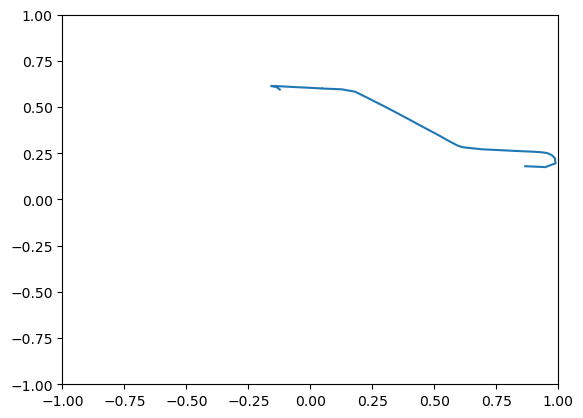

In [12]:
plt.plot(X[0, 0, :], X[0, 1, :])
plt.xlim(-1, 1)
plt.ylim(-1, 1)


In [19]:
flight_X = X[0].copy()
flight_X.shape

(2, 64)

In [20]:
flight_X = (flight_X + 1) * 32
flight_X = flight_X.astype(np.int32)
flight_X

array([[28, 27, 27, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 28, 29, 30, 31, 32, 33, 33, 33, 33, 33, 33,
        33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 47, 48, 49, 51, 51,
        54, 55, 58, 60, 60, 61, 62, 62, 63, 63, 63, 62, 61, 61, 61, 59],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 50, 49, 49, 48, 47, 45, 44, 43, 43, 42, 41, 41,
        40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 38, 37, 37, 37, 37, 37]],
      dtype=int32)

In [44]:
from scipy.interpolate import interp1d

inter_points = 512
t = np.linspace(0, 64, 512)
# Create interpolation functions for x and y coordinates
# interp_x = interp1d(t, np.arange(inter_points), flight_X[0], kind='linear')
interp_x = np.interp(t, np.arange(64), flight_X[0])
interp_y = np.interp(t, np.arange(64), flight_X[1])


In [65]:
# Create a 32 * 32 matrix
image_matrix = np.zeros((64, 64))

# Map the trajectory points to the matrix and fill the cells
for i in range(inter_points):
    x_pixel = int(interp_x[i])
    y_pixel = int(64 - interp_y[i])
    # image_matrix[y_pixel, x_pixel] += 1  # Mark the path
    if image_matrix[y_pixel, x_pixel] == 5:
        continue
    image_matrix[y_pixel, x_pixel] += 1  # Mark the path


In [52]:
from scipy.ndimage import gaussian_filter

In [66]:
filtered = gaussian_filter(image_matrix, sigma=0.5)

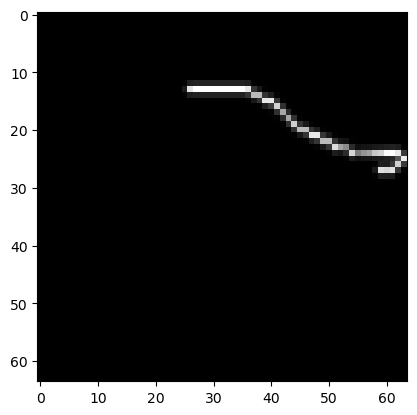

In [67]:
plt.imshow(filtered, cmap='gray')

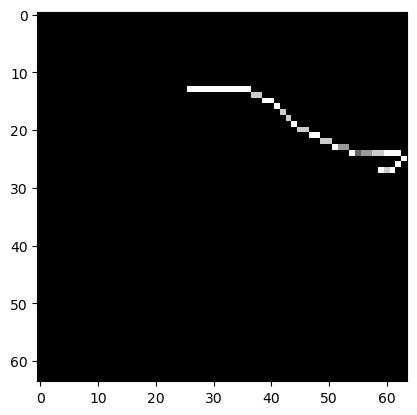

In [68]:
plt.imshow(image_matrix, cmap='gray')

In [ ]:
def 
inter_points = 512
t = np.linspace(0, 64, 512)
# Create interpolation functions for x and y coordinates
# interp_x = interp1d(t, np.arange(inter_points), flight_X[0], kind='linear')
interp_x = np.interp(t, np.arange(64), flight_X[0])
interp_y = np.interp(t, np.arange(64), flight_X[1])
